In [70]:
import os
import cv2
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import xgboost as xgb
from skimage import color
from skimage import io

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

import seaborn as sns
import keras 
from keras.callbacks import EarlyStopping, ModelCheckpoint

import warnings
warnings.filterwarnings('ignore')

from skimage.feature.texture import graycomatrix, graycoprops
from scipy.stats import skew, kurtosis

Text(0.5, 1, 'Normal')

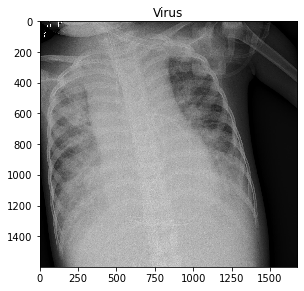

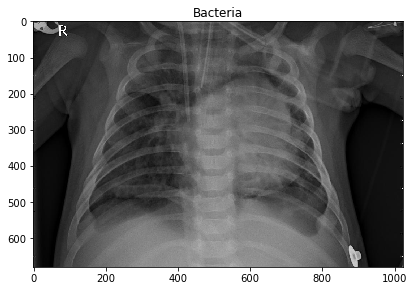

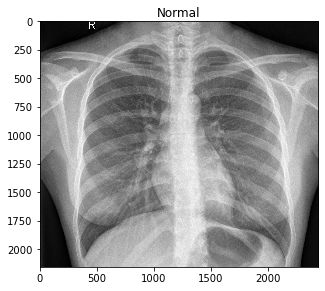

In [2]:
#load images and separate them into Normal, Bacterial Pneumonia, and Viral Pneumonia

folder_path = "C:\\Users\\matth\\OneDrive\\Desktop\\chest_xray\\all\\all"

normal = []
bacteria = []
virus = []

for filename in os.listdir(folder_path):
    if 'IM' in filename:
        normal.append(os.path.join(folder_path, filename))
    elif 'bacteria' in filename:
        bacteria.append(os.path.join(folder_path, filename))
    else:
        virus.append(os.path.join(folder_path, filename))
        
image_virus = io.imread(virus[10])
i, (im1) = plt.subplots(1)
i.set_figwidth(15)
io.imshow(image_virus)
i.suptitle('Virus', y = 1)

image_bacteria = io.imread(bacteria[10])
i, (im1) = plt.subplots(1)
i.set_figwidth(15)
io.imshow(image_bacteria)
i.suptitle('Bacteria', y = 1)

image_normal = io.imread(normal[10])
i, (im1) = plt.subplots(1)
i.set_figwidth(15)
io.imshow(image_normal)
i.suptitle('Normal', y = 1)

In [3]:
# Pre-processing images: Convert to grayscale, Resize into 127x127, and change pixel values to be out of 1.0

p_normal = []
p_bacteria = []
p_virus = []

size = 127

for image in normal:
    image = io.imread(image)
    image = image.astype(np.uint8)
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    image = cv2.resize(image,(size,size))
    image=image/255.0
    p_normal.append(image)
    
for image in bacteria:
    image = io.imread(image)
    image = image.astype(np.uint8)
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    image = cv2.resize(image,(size,size))
    image=image/255.0
    p_bacteria.append(image)
    
for image in virus:
    image = io.imread(image)
    image = image.astype(np.uint8)
    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    image = cv2.resize(image,(size,size))
    image=image/255.0
    p_virus.append(image)

In [4]:
images = {'normal': [], 'virus': [], 'bacteria': []}
for image in p_normal:
    images["normal"].append(image)
for image in p_virus:
    images["virus"].append(image)
for image in p_bacteria:
    images["bacteria"].append(image)

In [5]:
# Feature engineering for mean, standard deviation, skewness

means = []
stds = []
skewnesses = []
kurtoses = []

for key in images:
    for image in images[key]:
    
            # Convert the image data type to uint8
            image = (image * 255).astype(np.uint8)

            # Calculate statistics of pixel intensities
            mean = np.mean(image)
            std = np.std(image)
            skewness = np.mean(((image - mean) / std) ** 3)
            kurtosis = np.mean(((image - mean) / std) ** 4)

            # Append statistical features and label to respective lists
            means.append(mean)
            stds.append(std)
            skewnesses.append(skewness)
            kurtoses.append(kurtosis)

In [6]:
glcm_contrast = []
glcm_correlation = []

for key in images:
    for image in images[key]:
    
        # Convert the image data type to uint8
        image = (image * 255).astype(np.uint8)

        # Convert the color image to grayscale
#        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        # Calculate GLCM
        glcm = graycomatrix(image, [1], [0], symmetric=True, normed=True)

        # Calculate GLCM features (contrast and correlation)
        contrast = graycoprops(glcm, 'contrast')[0, 0]
        correlation = graycoprops(glcm, 'correlation')[0, 0]

        # Append GLCM features and label to respective lists
        glcm_contrast.append(contrast)
        glcm_correlation.append(correlation)

In [7]:
intensity_histograms = []

for key in images:
    for image in images[key]:
        
        # Convert the image data type to uint8
        image = (image * 255).astype(np.uint8)


        # Calculate Histogram of Pixel Intensities
        hist = cv2.calcHist([image], [0], None, [256], [0, 256])
        hist = hist.flatten()

        # Append intensity histogram features to the list
        intensity_histograms.append(hist)
    
# Create Pandas DataFrame with intensity histogram features
histogram = pd.DataFrame(intensity_histograms)
hist = histogram.T
hist_skew = hist.skew()
hist_kurt = hist.kurtosis()

In [8]:
glcm = pd.DataFrame({'GLCM_Contrast': glcm_contrast, 'GLCM_Correlation': glcm_correlation})
stat = pd.DataFrame({'Mean': means, 'Std': stds, 'Skewness': skewnesses, 'Kurtosis': kurtoses})
hist = pd.DataFrame({'hist_skew': hist_skew, 'hist_kurt': hist_kurt})

data = pd.concat([stat, glcm, hist], axis=1)
data

,Mean,Std,Skewness,Kurtosis,GLCM_Contrast,GLCM_Correlation,hist_skew,hist_kurt
0,130.930250,56.957910,-0.276439,2.290696,258.313461,0.959971,-0.049279,-1.191745
1,142.465993,60.328784,-0.457029,2.178626,251.418448,0.964944,0.021408,-1.060893
2,136.214582,55.323598,-0.382820,2.400305,260.084864,0.957075,-0.167756,-1.386482
3,148.712691,41.977999,-0.250405,2.365548,174.868641,0.950026,0.023060,-1.689238
4,137.675491,53.725366,-0.224385,2.381007,292.589739,0.948890,-0.172160,-1.273743
...,...,...,...,...,...,...,...,...
5851,125.316201,63.227970,-0.560426,2.319170,302.335521,0.961544,11.896592,172.094849
5852,132.348069,53.853404,-0.789765,2.581166,184.834146,0.967513,1.153434,0.965491
5853,127.615413,49.643708,-0.566418,2.514584,100.651856,0.979078,0.737014,0.650150
5854,144.579329,51.488092,-1.065413,3.285274,158.790526,0.969297,1.349190,1.414894


In [19]:
length = []
for key in images:
    length.append(len(images[key]))
length
labels = []
for i in range(0,length[0]):
    labels.append('normal')
for i in range(length[0], length[0]+length[1]+length[2]):
    labels.append('pneuomonia')

labels = pd.DataFrame({'labels': labels})

In [20]:
data = pd.concat([data, labels], axis = 1)

In [39]:
x = data.iloc[:,0:8]
y = data.iloc[:,8]

In [40]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(y)
y = le.transform(y)

In [42]:
# Test = 20%, Training = 80%
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1, stratify = y)

In [51]:
dtrain = xgb.DMatrix(data=x_train,label=y_train)
dtest = xgb.DMatrix(data=x_test,label=y_test)

In [63]:
import xgboost as xgb

params = {'eta': 0.1, 'max_depth': 5, 'objective': 'multi:softprob'}

cv_results = xgb.cv(dtrain=dtrain, params=params, nfold=10,
                    num_boost_round=2000, 
                    metrics="mlogloss", as_pandas=True, seed=1)

cv_results
cv_results[cv_results['test-mlogloss-mean'] == cv_results['test-mlogloss-mean'].min()]

# n_estimators = 104 is the best as it returns lowest test-mlogloss-mean

,train-logloss-mean,train-logloss-std,test-logloss-mean,test-logloss-std
115,0.190286,0.003373,0.317885,0.027038


In [115]:
import xgboost as xgb

# From above we fit a basic xgb model
xgb = xgb.XGBClassifier(n_estimators = 115,
                        eta = 0.01, 
                        max_depth = 5,
                        num_class = 2, 
                        objective = 'multi:softmax', 
                        seed = 123)

xgb.fit(x_train, y_train)

y_pred = xgb.predict(x_test)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
score = f1_score(y_test, y_pred, average='weighted')
print('Balanced Accuracy:', round(balanced_accuracy, 5))
print('Weighted F1 Score:', round(score,5))

Balanced Accuracy: 0.80547
Weighted F1 Score: 0.84299


In [576]:
import xgboost as xgb
# from Trialing, we insert tuned hyperparameters into XGB

xgb = xgb.XGBClassifier(n_estimators = 900, 
                        eta = 0.503663556910949, 
                        gamma = 0.5810548115324397,
                        max_depth = 6, 
                        num_class = 3, 
                        objective = 'multi:softmax', 
                        reg_lambda =  0.6714260976698774,
                        min_child_weight = 3,
                        seed = 123)

xgb.fit(x_train, y_train)

y_pred = xgb.predict(x_val)
accuracy = accuracy_score(y_val, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

#accuracy = 71.33

Accuracy: 68.77%


In [581]:
import xgboost as xgb
# increase complexity by increasing number of trees and lowering learning rate
xgb = xgb.XGBClassifier(n_estimators = 1200, 
                        eta = 0.01, 
                        gamma = 0.5810548115324397,
                        max_depth = 6, 
                        num_class = 3, 
                        objective = 'multi:softmax', 
                        reg_lambda =  0.6714260976698774,
                        min_child_weight = 3,
                        seed = 123)

xgb.fit(x_train, y_train)

y_pred = xgb.predict(x_val)
accuracy = accuracy_score(y_val, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

#accuracy = 72.18

y_pred = xgb.predict(x_test)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 72.18%
Accuracy: 68.60%


In [134]:
#use to test for hyperparameter tuning below

import xgboost as xgb

xgb = xgb.XGBClassifier(n_estimators = 395,
                        learning_rate = 0.03, 
                        max_depth=5,
                        objective= 'multi:softmax', 
                        seed=123, 
                        num_class = 2,
                        min_child_weight = 1,
                        gamma = 0.24,
                        colsample_bytree = 0.9,
                        subsample = 0.75,
                        reg_alpha = 0.074,
                        reg_lambda = 0.19)

xgb.fit(x_train, y_train)

y_pred = xgb.predict(x_test)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
score = f1_score(y_test, y_pred, average='weighted')
print('Balanced Accuracy:', round(balanced_accuracy, 5))
print('Weighted F1 Score:', round(score,5))

Balanced Accuracy: 0.82365
Weighted F1 Score: 0.86371


In [117]:
import xgboost as xgb
#different approach for parameter tuning. use values from first parameter testing. test for maX_depth and min_child_weight

param_test1 = {
 'max_depth':[1,2,3,4,5],
 'min_child_weight':[0,1,2,3,4,5,6,7,8,9,10]
}
gsearch1 = GridSearchCV(estimator = xgb.XGBClassifier(
                                            n_estimators = 115,
                                            learning_rate = 0.01, 
                                            max_depth=5,
                                            objective= 'multi:softmax', 
                                            seed=123, 
                                            num_class = 2, 
), param_grid = param_test1, scoring='f1_weighted',n_jobs=4, cv=5)

gsearch1.fit(x_train,y_train)
gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_

# best is max_depth = 5, min_child_weight = 1

({'mean_fit_time': array([0.17924628, 0.12727594, 0.12772775, 0.12941675, 0.12905359,
         0.12339783, 0.13156924, 0.12785192, 0.12758794, 0.12419748,
         0.1270402 , 0.16954546, 0.17166467, 0.16989913, 0.16150484,
         0.17618442, 0.17752194, 0.19283781, 0.18333778, 0.18700953,
         0.17506948, 0.17786789, 0.22664428, 0.23438826, 0.23054085,
         0.22626929, 0.23980007, 0.23428931, 0.22992373, 0.22752209,
         0.23248339, 0.23858395, 0.24233279, 0.32020059, 0.31310058,
         0.33177819, 0.32572813, 0.32075858, 0.30016565, 0.32034588,
         0.31017213, 0.29324565, 0.29753623, 0.30071044, 0.47055173,
         0.44198704, 0.44012876, 0.43257079, 0.43526955, 0.42382627,
         0.40929236, 0.41398902, 0.41357713, 0.41614399, 0.40624146]),
  'std_fit_time': array([2.59475619e-02, 1.26014081e-02, 5.03633501e-05, 8.80284735e-03,
         6.88402440e-03, 4.71565092e-03, 5.37813117e-03, 1.30236775e-03,
         6.50044304e-03, 4.54754499e-03, 8.11951041e-03, 8.0

In [118]:
import xgboost as xgb
# find best gamma
param_test1 = {
 'gamma':[i/10.0 for i in range(0,10)]
}

gsearch1 = GridSearchCV(estimator = xgb.XGBClassifier(
                                            n_estimators = 115,
                                            learning_rate = 0.01, 
                                            max_depth=5,
                                            objective= 'multi:softmax', 
                                            seed=123, 
                                            num_class = 2,
                                            min_child_weight = 1
), param_grid = param_test1, scoring='f1_weighted',n_jobs=4, cv=5)

gsearch1.fit(x_train,y_train)
gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_
# best gamma is around 0.3

({'mean_fit_time': array([0.50557837, 0.42536383, 0.44597139, 0.43832417, 0.43672919,
         0.4208149 , 0.42030168, 0.43465695, 0.42012954, 0.38362164]),
  'std_fit_time': array([0.04517657, 0.01474187, 0.00879909, 0.00433667, 0.006537  ,
         0.01633138, 0.00853812, 0.00993963, 0.00753639, 0.03770651]),
  'mean_score_time': array([0.00974083, 0.00980244, 0.01019487, 0.00957212, 0.00979524,
         0.0093852 , 0.01019497, 0.00813231, 0.01052179, 0.00607572]),
  'std_score_time': array([8.01139884e-04, 7.89852601e-04, 2.03155015e-05, 4.61848379e-03,
         8.19783879e-04, 1.01590461e-03, 6.31296021e-05, 3.16877189e-03,
         3.00464315e-03, 4.25607131e-03]),
  'param_gamma': masked_array(data=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
               mask=[False, False, False, False, False, False, False, False,
                     False, False],
         fill_value='?',
              dtype=object),
  'params': [{'gamma': 0.0},
   {'gamma': 0.1},
   {'gamma': 0.2},


In [119]:
import xgboost as xgb
# find more accurate gamma around 0.3

param_test1 = {
 'gamma':np.arange(0.2, 0.4, 0.01)
}

gsearch1 = GridSearchCV(estimator = xgb.XGBClassifier(
                                            n_estimators = 115,
                                            learning_rate = 0.01, 
                                            max_depth=5,
                                            objective= 'multi:softmax', 
                                            seed=123, 
                                            num_class = 2,
                                            min_child_weight = 1
), param_grid = param_test1, scoring='f1_weighted',n_jobs=4, cv=5)

gsearch1.fit(x_train,y_train)
gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_

# best gamma is 0.24

({'mean_fit_time': array([0.50808411, 0.44679246, 0.44043131, 0.41833515, 0.42085471,
         0.44343953, 0.46025925, 0.43389602, 0.43563814, 0.43719721,
         0.44206009, 0.44122448, 0.42365055, 0.42831807, 0.42765579,
         0.41722088, 0.42260695, 0.42491531, 0.41966028, 0.40912876]),
  'std_fit_time': array([0.0312661 , 0.00604518, 0.01383101, 0.00810617, 0.00910401,
         0.01318045, 0.00960261, 0.00752396, 0.00602085, 0.00655754,
         0.01441141, 0.00704502, 0.00591185, 0.00439622, 0.01163494,
         0.01060555, 0.00454437, 0.00521223, 0.01009263, 0.01369423]),
  'mean_score_time': array([0.00896893, 0.01018553, 0.00892248, 0.00980277, 0.00977054,
         0.00974488, 0.00979266, 0.00938067, 0.01022878, 0.01017504,
         0.00726495, 0.00979362, 0.01019254, 0.00896139, 0.0085557 ,
         0.00977097, 0.00650582, 0.00774827, 0.01017509, 0.00979786]),
  'std_score_time': array([9.97728031e-04, 9.50976370e-06, 1.05481084e-03, 8.03902103e-04,
         8.18170524e-04

In [121]:
#test for optimal subsample, and colsample_bytree
param_test1 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}

gsearch1 = GridSearchCV(estimator = xgb.XGBClassifier(
                                            n_estimators = 115,
                                            learning_rate = 0.01, 
                                            max_depth=5,
                                            objective= 'multi:softmax', 
                                            seed=123, 
                                            num_class = 2,
                                            min_child_weight = 1,
                                            gamma = 0.24
), param_grid = param_test1, scoring='f1_weighted',n_jobs=4, cv=5)

gsearch1.fit(x_train,y_train)
gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_

#colsample_bytree = ~0.9, subsample = ~0.7

({'mean_fit_time': array([0.41684375, 0.38748379, 0.40154018, 0.38988438, 0.42969413,
         0.43581529, 0.43677406, 0.41624317, 0.47153573, 0.42080107,
         0.400805  , 0.40611076, 0.42337627, 0.43067131, 0.42536054,
         0.42077751]),
  'std_fit_time': array([0.02881906, 0.00725125, 0.01674047, 0.02176844, 0.01540539,
         0.03121338, 0.00883824, 0.00854706, 0.03787004, 0.02016968,
         0.00774276, 0.01203266, 0.00418333, 0.00735829, 0.01189161,
         0.01135062]),
  'mean_score_time': array([0.01018553, 0.00857782, 0.01059198, 0.00977392, 0.00698471,
         0.01021652, 0.0102109 , 0.00777168, 0.01499624, 0.00938601,
         0.00813742, 0.00955491, 0.00973792, 0.00902886, 0.00689425,
         0.00855355]),
  'std_score_time': array([2.67153949e-05, 3.27464370e-03, 8.49087648e-04, 8.05215814e-04,
         3.94695346e-03, 2.57127115e-05, 8.73224117e-06, 3.01292877e-03,
         1.06649857e-02, 9.86762884e-04, 3.14491242e-03, 2.12666404e-03,
         8.77375867e-

In [124]:
#fine tune subsample and colsample_bytree values
param_test1 = {
 'subsample':[i/100.0 for i in range(70,90,5)],
 'colsample_bytree':[i/100.0 for i in range(80,100,5)]
}

gsearch1 = GridSearchCV(estimator = xgb.XGBClassifier(
                                            n_estimators = 115,
                                            learning_rate = 0.01, 
                                            max_depth=5,
                                            objective= 'multi:softmax', 
                                            seed=123, 
                                            num_class = 2,
                                            min_child_weight = 1,
                                            gamma = 0.24
), param_grid = param_test1, scoring='f1_weighted',n_jobs=4, cv=5)

gsearch1.fit(x_train,y_train)
gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_

# best values are 'colsample_bytree': 0.9, 'subsample': 0.75

({'mean_fit_time': array([0.49066792, 0.40950856, 0.40926342, 0.3911355 , 0.40263481,
         0.39204669, 0.40623546, 0.40012703, 0.42291608, 0.42628813,
         0.43757558, 0.45177703, 0.44576921, 0.43621411, 0.41756272,
         0.4294879 ]),
  'std_fit_time': array([0.0300717 , 0.02092139, 0.0053993 , 0.01378693, 0.01374819,
         0.00593218, 0.01530574, 0.01442505, 0.00377989, 0.01083192,
         0.00670107, 0.01893545, 0.00876376, 0.01687578, 0.01135446,
         0.00361727]),
  'mean_score_time': array([0.00974169, 0.00855756, 0.00979753, 0.00978322, 0.01018128,
         0.01028223, 0.00649505, 0.0097518 , 0.00692544, 0.00895443,
         0.00934749, 0.00975323, 0.00775175, 0.00979133, 0.01020555,
         0.00932503]),
  'std_score_time': array([8.01069035e-04, 3.26077763e-03, 8.09266995e-04, 8.19815622e-04,
         3.86731104e-05, 2.01477970e-04, 3.65018439e-03, 8.13587099e-04,
         3.99438037e-03, 1.01934822e-03, 4.60707530e-03, 8.86438161e-04,
         2.99462828e-

In [126]:
# test for reg_alpha and reg_lambda
import xgboost as xgb

param_test1 = {
 'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05,0.1,0.2,0.3],
 'reg_lambda':[0, 0.001, 0.005, 0.01, 0.05,0.1,0.2,0.3]
}

gsearch1 = GridSearchCV(estimator = xgb.XGBClassifier(
                                            n_estimators = 115,
                                            learning_rate = 0.01, 
                                            max_depth=5,
                                            objective= 'multi:softmax', 
                                            seed=123, 
                                            num_class = 2,
                                            min_child_weight = 1,
                                            gamma = 0.24,
                                            colsample_bytree = 0.9,
                                            subsample = 0.75
), param_grid = param_test1, scoring='f1_weighted',n_jobs=4, cv=5)

gsearch1.fit(x_train,y_train)
gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_


# best reg_alpha = 0.05, reg_lambda = ~0.1

({'mean_fit_time': array([0.47186489, 0.44587398, 0.44526262, 0.4347084 , 0.42696028,
         0.445121  , 0.43916359, 0.45051308, 0.41911116, 0.42751546,
         0.4169107 , 0.4328702 , 0.4334651 , 0.45258889, 0.44932475,
         0.44487915, 0.4494976 , 0.46484404, 0.45886059, 0.44737225,
         0.43582573, 0.43205919, 0.46100631, 0.45218487, 0.46116405,
         0.42933788, 0.42976341, 0.42553525, 0.42568536, 0.43138747,
         0.42752185, 0.41988382, 0.4242743 , 0.41923165, 0.42801843,
         0.42836523, 0.42593307, 0.43820109, 0.45947628, 0.44484   ,
         0.45141578, 0.46614785, 0.45096292, 0.45203547, 0.4270328 ,
         0.46627994, 0.46841979, 0.43056593, 0.41824121, 0.42618165,
         0.41423154, 0.42370582, 0.45971942, 0.45463738, 0.44132638,
         0.41163111, 0.42021527, 0.41684089, 0.42957191, 0.44215436,
         0.42345529, 0.44676242, 0.45476274, 0.4451982 ]),
  'std_fit_time': array([0.01301916, 0.01003978, 0.00512039, 0.01053568, 0.00962549,
         0.

In [127]:
#fine tune reg_alpha, reg_labda

import xgboost as xgb

param_test1 = {
 'reg_lambda':np.arange(0.0, 0.2, 0.01),
 'reg_alpha':np.arange(0.0, 0.1, 0.001)
}

gsearch1 = GridSearchCV(estimator = xgb.XGBClassifier(
                                            n_estimators = 115,
                                            learning_rate = 0.01, 
                                            max_depth=5,
                                            objective= 'multi:softmax', 
                                            seed=123, 
                                            num_class = 2,
                                            min_child_weight = 1,
                                            gamma = 0.24,
                                            colsample_bytree = 0.9,
                                            subsample = 0.75,
                                            
), param_grid = param_test1, scoring='f1_weighted',n_jobs=4, cv=5)

gsearch1.fit(x_train,y_train)
gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_

#best is reg_lambda = 0.19, reg_alpha = 0.074

({'mean_fit_time': array([0.49349513, 0.44372621, 0.4706841 , ..., 0.43337278, 0.43177981,
         0.41844358]),
  'std_fit_time': array([0.03693434, 0.02872645, 0.00840164, ..., 0.0047999 , 0.00841607,
         0.0151254 ]),
  'mean_score_time': array([0.00694375, 0.0113441 , 0.00975337, ..., 0.00939174, 0.00816503,
         0.00907679]),
  'std_score_time': array([0.00400567, 0.00230938, 0.00080883, ..., 0.00099375, 0.0031674 ,
         0.00092267]),
  'param_reg_alpha': masked_array(data=[0.0, 0.0, 0.0, ..., 0.099, 0.099, 0.099],
               mask=[False, False, False, ..., False, False, False],
         fill_value='?',
              dtype=object),
  'param_reg_lambda': masked_array(data=[0.0, 0.01, 0.02, ..., 0.17, 0.18, 0.19],
               mask=[False, False, False, ..., False, False, False],
         fill_value='?',
              dtype=object),
  'params': [{'reg_alpha': 0.0, 'reg_lambda': 0.0},
   {'reg_alpha': 0.0, 'reg_lambda': 0.01},
   {'reg_alpha': 0.0, 'reg_lambda': 0

In [129]:
# find best number of trees and learning rate
import xgboost as xgb

param_test1 = {
 'learning_rate':np.arange(0.01, 0.1, 0.01),
 'n_estimators': range(100,2000,100)
}

gsearch1 = GridSearchCV(estimator = xgb.XGBClassifier(
                                            n_estimators = 115,
                                            learning_rate = 0.01, 
                                            max_depth=5,
                                            objective= 'multi:softmax', 
                                            seed=123, 
                                            num_class = 2,
                                            min_child_weight = 1,
                                            gamma = 0.24,
                                            colsample_bytree = 0.9,
                                            subsample = 0.75,
                                            reg_alpha = 0.074,
                                            reg_lambda = 0.19
), param_grid = param_test1, scoring='f1_weighted',n_jobs=4, cv=5)

gsearch1.fit(x_train,y_train)
gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_

({'mean_fit_time': array([ 0.43406615,  0.72244701,  1.04807749,  1.37243791,  1.69423933,
          2.07329254,  2.45460854,  2.75388002,  2.98047538,  3.44148026,
          3.82313061,  4.0979629 ,  4.46138906,  4.55182772,  4.84408178,
          5.47598395,  5.99076672, 11.13305049,  8.49188371,  0.45856481,
          0.87097411,  1.17988429,  1.59587951,  1.8566628 ,  2.21313887,
          2.72945938,  3.01816521,  3.1987401 ,  3.5687767 ,  4.11899352,
          4.16120892,  4.31327481,  4.54112635,  4.6579102 ,  4.86998754,
          5.5157536 ,  6.27881179,  6.01543999,  0.38104582,  0.75348349,
          1.15212092,  1.64974089,  1.97290063,  2.11182365,  2.2769701 ,
          2.80497456,  2.89958177,  3.10834074,  3.35423317,  3.55142059,
          4.52727633,  4.14114451,  4.16319976,  4.23504972,  4.3754106 ,
          4.47527685,  4.72719297,  0.36279182,  0.68185902,  0.99588771,
          1.31151624,  1.62371836,  1.90937171,  2.19392686,  2.42974906,
          2.62228265,

In [130]:
# fine tune best number of trees and learning rate
import xgboost as xgb

param_test1 = {
 'learning_rate':np.arange(0.02, 0.04, 0.001),
 'n_estimators': range(350,450,5)
}

gsearch1 = GridSearchCV(estimator = xgb.XGBClassifier(
                                            n_estimators = 115,
                                            learning_rate = 0.01, 
                                            max_depth=5,
                                            objective= 'multi:softmax', 
                                            seed=123, 
                                            num_class = 2,
                                            min_child_weight = 1,
                                            gamma = 0.24,
                                            colsample_bytree = 0.9,
                                            subsample = 0.75,
                                            reg_alpha = 0.074,
                                            reg_lambda = 0.19
), param_grid = param_test1, scoring='f1_weighted',n_jobs=4, cv=5)

gsearch1.fit(x_train,y_train)
gsearch1.cv_results_, gsearch1.best_params_, gsearch1.best_score_

# best learning rate = 0.03, number of trees = 395

({'mean_fit_time': array([1.38083997, 1.23673916, 1.24931622, 1.22712941, 1.25853548,
         1.26791992, 1.29180841, 1.29023924, 1.30035291, 1.32307553,
         1.34372325, 1.37155514, 1.37854919, 1.3754066 , 1.40014553,
         1.43923554, 1.44925284, 1.47833509, 1.48493938, 1.49201388,
         1.17570658, 1.20490322, 1.2055831 , 1.21900077, 1.24017959,
         1.27792401, 1.29524989, 1.2989162 , 1.39869871, 1.35058947,
         1.35284257, 1.36266799, 1.35535746, 1.5197217 , 1.42706413,
         1.43690767, 1.43664727, 1.46453242, 1.48400888, 1.50357842,
         1.18070335, 1.17773628, 1.21976786, 1.22749457, 1.22990103,
         1.25381861, 1.28837614, 1.30250478, 1.29118266, 1.33414464,
         1.44001908, 1.4930573 , 1.51053791, 1.51596694, 1.54544544,
         1.51577735, 1.56037583, 1.58365054, 1.59181542, 1.60461273,
         1.27842908, 1.31539741, 1.30923343, 1.31567483, 1.33980646,
         1.39845309, 1.33017564, 1.41929512, 1.41893821, 1.43787723,
         1.441475

In [135]:
#final XGB model

#use to test for hyperparameter tuning below

import xgboost as xgb

xgb = xgb.XGBClassifier(n_estimators = 395,
                        learning_rate = 0.03, 
                        max_depth=5,
                        objective= 'multi:softmax', 
                        seed=123, 
                        num_class = 2,
                        min_child_weight = 1,
                        gamma = 0.24,
                        colsample_bytree = 0.9,
                        subsample = 0.75,
                        reg_alpha = 0.074,
                        reg_lambda = 0.19)

xgb.fit(x_train, y_train)

y_pred = xgb.predict(x_test)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
score = f1_score(y_test, y_pred, average='weighted')
print('Balanced Accuracy:', round(balanced_accuracy, 5))
print('Weighted F1 Score:', round(score,5))

Balanced Accuracy: 0.82365
Weighted F1 Score: 0.86371


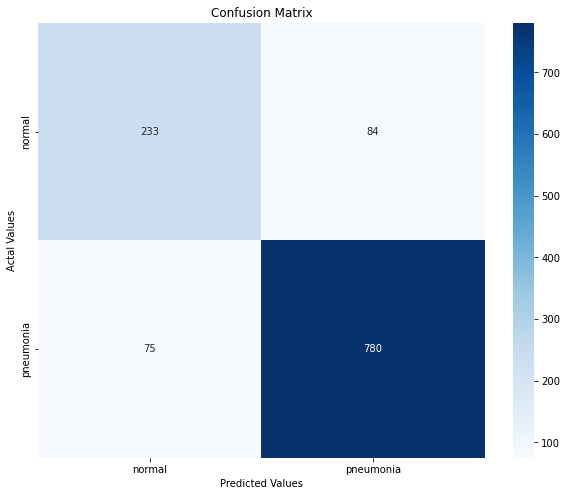

In [138]:
# insert values for confusion matrix

cm = confusion_matrix(y_test, y_pred)

cm_df = pd.DataFrame(cm,
                     index = ['normal','pneumonia'], 
                     columns = ['normal','pneumonia'])

plt.figure(figsize=(10,8))
sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [139]:
# print classification report

print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.74      0.75       317
           1       0.90      0.91      0.91       855

    accuracy                           0.86      1172
   macro avg       0.83      0.82      0.83      1172
weighted avg       0.86      0.86      0.86      1172

